# Instalação do detectron2 e sua dependências

In [1]:
# Instalação das dependências 
!pip install pyyaml==5.1
import torch, torchvision

# Instala detectron2: (Colab tem CUDA 10.1 + torch 1.7)
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

# APÓS A INSTALAÇÃO É NECESSÁRIO UM "restart runtime"

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


# Importação das principais bibliotecas e alguns recursos do detectron2

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import pandas as pd
import os, json, cv2, random, glob, csv, configparser
from google.colab.patches import cv2_imshow
from scipy.spatial import distance

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode, GenericMask

from google.colab import drive
drive.mount('/content/drive')

config = configparser.ConfigParser()
config.read("config.ini")

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['config.ini']

In [3]:
def centroids_calc(output_file, predictor, files):
  """
    Calcula os centroids de um conjunto de arquivos de imagem e salva em um csv.

    Args:
      output_file: str
        Caminho do arquivo csv de saída com os centroids.

      predictor: 
        Modelo para inferência

      files: list
        Lista com os caminhos das imagens a serem classificadas.
  """
  
  centroids = []

  for filee in files:
    im = cv2.imread(filee)
    outputs = predictor(im)
    mask = outputs["instances"].pred_masks.to("cpu").numpy()[0]
    mask = np.ascontiguousarray(mask)
    res = cv2.findContours(mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    # Calcula o centroide do contorno.
    M = cv2.moments(res[0][0])
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    centroids.append([filee.split("/")[-1], cx, cy])

  with open(output_file, mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for cent in centroids:
      csv_writer.writerow(cent)

def calc_avg_euclidean_dist(file_path_a, file_path_b):
  """
    Calcula a distância euclidiana média entre dois conjuntos de centróides.
    Considerando que cada centróide no grupo 'a' possua seu correspondente
    no grupo 'b'

    Args:
      file_path_a, file_path_b : str
        caminho dos arquivos csv a serem carregados. considera-se que o arquivo
        csv contenha 3 colunas (nome_do_arquivo, coord_x, coord_y).

    Returns:
      distância euclideana média em pixels.
  """

  # Carrega arquivos e cria dataframe
  df_a = pd.read_csv(file_path_a, sep=',', names=['name', 'coord_x', 'coord_y'])
  df_b = pd.read_csv(file_path_b, sep=',', names=['name', 'coord_x', 'coord_y'])

  # converte para np.ndarray
  array_a = df_a[['coord_x', 'coord_y']].to_numpy()
  array_b = df_b[['coord_x', 'coord_y']].to_numpy()

  # Calcula a distância euclideana de cada coordenada do conjunto 'a' para cada
  # coordenada do conjunto 'b'. Portanto, as únicas distâncias que nos
  # interessam são as da diagonal principal.
  dists = np.diag(distance.cdist(array_a, array_b, 'euclidean'))

  return dists.mean()

## Treinamento

In [4]:
# Estamos habilitando o acesso ao google drive onde a base de dados está
# localizada.
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wally_dataset_train", {}, config['DEFAULT']['AnnotationsFile'], config['DEFAULT']['DatasetPath'])

In [5]:
from detectron2.engine import DefaultTrainer

# Vamos utilizar um modelo pré-treinado com a base COCO, uma maskrcnn resnet50.
# Os principais hiperparâmetros são configurados, como o valor inicial da taxa 
# de aprendizagem, tamanho do batch, total de iterações e número de classes.
# Como só estamos tentando identificar o Wally, teremos uma única classe.
# Todos os outros parâmetros estão definidos como padrão para este modelo. 
# Obviamente, para uma base de dados mais complexa, podemos buscar ajustar
# a taxa inicial de aprendizagem, configurar o seu decaimento ao longo das
# épocas (configurando os parâmetros cfg.SOLVER.STEPS para as iterações 
# em que seriam aplicadas o decaimento e cfg.SOLVER.GAMMA que define
# o multiplicado a ser aplicado à taxa inicial de aprendizagem), 
# definir quantas iterações são suficientes para o treinamento,
# aplicar `augmentations` para melhorar a variabilidade do conjunto de
# dados etc.
# Mais detalhes sobre os hiperparâmetros e como configurá-los, vide
# https://detectron2.readthedocs.io/en/latest/modules/config.html#config-references
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.OUTPUT_DIR = config['DEFAULT']['OutputDir']
cfg.DATASETS.TRAIN = ("wally_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.003
cfg.SOLVER.MAX_ITER = 800
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# No processo de inferência, detecções que possuem 
# a área dos retângulos com mais de 10% de sobreposição com outra detecção
# da mesma classe serão descartadas.
# Non-max Supression for boxes (NMS).
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1

# Apenas detecções acima de 50% de confidência serão consideradas.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(config['DEFAULT']['ConfigYamlFile'], "w") as f:
    f.write(cfg.dump())

In [6]:
# Treina o modelo.
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/14 19:44:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[02/14 19:44:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/

[02/14 19:44:13 d2.utils.events]:  eta: 0:05:41  iter: 19  total_loss: 1.473  loss_cls: 0.6185  loss_box_reg: 0.1714  loss_mask: 0.6717  loss_rpn_cls: 0.004214  loss_rpn_loc: 0.002857  time: 0.4252  data_time: 0.0450  lr: 5.9943e-05  max_mem: 2335M
[02/14 19:44:22 d2.utils.events]:  eta: 0:05:32  iter: 39  total_loss: 0.8822  loss_cls: 0.1772  loss_box_reg: 0.1964  loss_mask: 0.5043  loss_rpn_cls: 0.001296  loss_rpn_loc: 0.002347  time: 0.4320  data_time: 0.0066  lr: 0.00011988  max_mem: 2335M
[02/14 19:44:31 d2.utils.events]:  eta: 0:05:24  iter: 59  total_loss: 0.5504  loss_cls: 0.1137  loss_box_reg: 0.1755  loss_mask: 0.2576  loss_rpn_cls: 0.0007134  loss_rpn_loc: 0.002144  time: 0.4344  data_time: 0.0089  lr: 0.00017982  max_mem: 2335M
[02/14 19:44:40 d2.utils.events]:  eta: 0:05:15  iter: 79  total_loss: 0.414  loss_cls: 0.08876  loss_box_reg: 0.1893  loss_mask: 0.1311  loss_rpn_cls: 0.0003574  loss_rpn_loc: 0.002573  time: 0.4346  data_time: 0.0066  lr: 0.00023976  max_mem: 2388M

## Inferência e geração dos resultados




In [7]:
# Criamos uma nova instância do modelo para teste, carregamos o arquivo
# de configuração e os pesos do último modelo treinado.
cfg_test = get_cfg()
cfg_test.merge_from_file(config['DEFAULT']['ConfigYamlFile'])
cfg.MODEL.WEIGHTS = config['DEFAULT']['ModelFile']
predictor = DefaultPredictor(cfg)

train_files = sorted(glob.glob(config['DEFAULT']['TrainingSetPath']+"/*.jpg"))
test_files = sorted(glob.glob(config['DEFAULT']['TestSetPath']+"/*.jpg"))

centroids_calc(config['DEFAULT']['TrainingResultsFile'], predictor, train_files)
centroids_calc(config['DEFAULT']['TestResultsFile'], predictor, test_files)

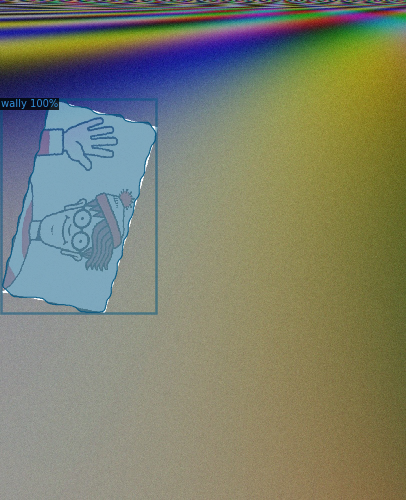

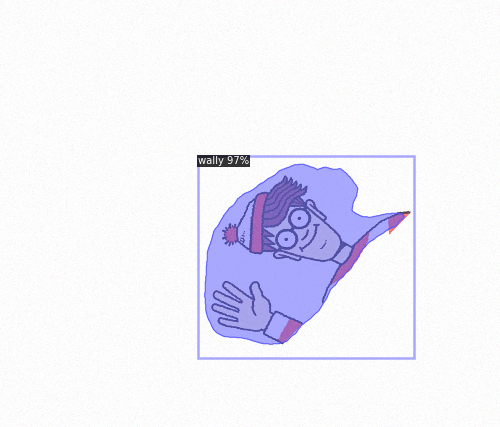

In [10]:
# Apenas para visualizar o resultado das detecções.
img1 = cv2.imread(test_files[1])
img2 = cv2.imread(test_files[2])

pred1 = predictor(img1)
pred2 = predictor(img2)

v = Visualizer(img1[:,:,::-1], {"thing_classes":["wally"]}, scale=0.5)
out1 = v.draw_instance_predictions(pred1["instances"].to("cpu"))
cv2_imshow(out1.get_image()[:, :, ::-1])

v = Visualizer(img2[:,:,::-1], {"thing_classes":["wally"]}, scale=0.5)
out2 = v.draw_instance_predictions(pred2["instances"].to("cpu"))
cv2_imshow(out2.get_image()[:, :, ::-1])

In [9]:
# Avalia distância euclideana média entre os centróides.
print(calc_avg_euclidean_dist(config['DEFAULT']['ReferenceData'], config['DEFAULT']['TrainingResultsFile']))

8.711928686433884
